In [16]:
%load_ext nb_black
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

Read the data
===========

In [17]:
# x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
# y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')

# x_original=x_original[['Unnamed: 0','L100800', 'L104600', 'S000300', 'SEX', 'S000501', 'L101700',
#        'L190400', 'S000502', 'L190500', 'L101300', 'AGE', 'FIELD_38',
#        'FIELD_31', 'FIELD_41'
#                       ]]

# y_original=y_original[['Unnamed: 0','L100800' ]]


# print(x_original.shape)
# print(y_original.shape)

<IPython.core.display.Javascript object>

In [18]:
# for index,col in enumerate(x_original.columns):
#     print(col,x_original[col].dropna().shape[0])

<IPython.core.display.Javascript object>

Prepare the data
============

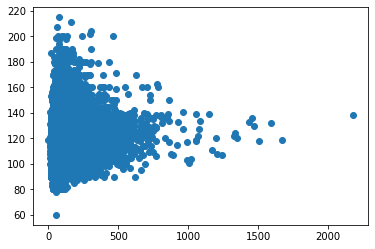

<IPython.core.display.Javascript object>

In [46]:
plt.scatter(data.L103000, data.S000501)

In [19]:
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")
data["max"] = np.min(data[["FIELD_6", "FIELD_7"]], axis=1)
data = data.drop(columns=["FIELD_6", "FIELD_7"])

# change field 38 to 3 group
condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)

data = data[
    [
        "S000501",
        "S000300",
        "L190300",
        "L100700",
        "L103300",
        "L103000",
        "L100800",
        "L100500",
        "S000100",
        "L101700",
        "max",
        "L101300",
        "L101600",
        "L103100",
        "S010101",
        "S010102",
        "SEX",
        "FIELD_38_C",
        "FIELD_33",
        "FIELD_38",
        "FIELD_40",
        "FIELD_29",
        "FIELD_41",
        "FIELD_27",
        "FIELD_42",
        "AGE",
    ]
]
data = data.dropna().reset_index()

# data=data[data.FIELD_15==0]
# data=data[data.FIELD_22==0]
# data=data[data.SEX==0]
# data=data[data.AGE < 40]

print(data.shape)

(153989, 27)


<IPython.core.display.Javascript object>

In [20]:
print(data.shape)
print(data.columns)
data.head()

(153989, 27)
Index(['index', 'S000501', 'S000300', 'L190300', 'L100700', 'L103300',
       'L103000', 'L100800', 'L100500', 'S000100', 'L101700', 'max', 'L101300',
       'L101600', 'L103100', 'S010101', 'S010102', 'SEX', 'FIELD_38_C',
       'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_29', 'FIELD_41', 'FIELD_27',
       'FIELD_42', 'AGE'],
      dtype='object')


,index,S000501,S000300,L190300,L100700,L103300,L103000,L100800,L100500,S000100,...,SEX,FIELD_38_C,FIELD_33,FIELD_38,FIELD_40,FIELD_29,FIELD_41,FIELD_27,FIELD_42,AGE
0,5,123.0,22.9,4.30,4.2,3.9,66.0,93.0,0.9,159.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,46.0
1,18,109.0,20.1,3.84,4.5,2.9,45.0,101.0,0.8,156.3,...,1.0,1.0,1.0,1.0,5.0,0.0,1.0,0.0,6.0,47.0
2,19,105.0,19.9,3.94,4.9,3.0,39.0,94.0,0.8,157.0,...,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.0,6.0,48.0
3,20,119.0,21.0,3.78,4.7,3.0,45.0,98.0,0.9,156.0,...,1.0,1.0,1.0,1.0,5.0,0.0,7.0,0.0,7.0,49.0
4,21,111.0,20.3,3.73,4.1,3.2,75.0,106.0,0.9,157.0,...,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.0,7.0,50.0


<IPython.core.display.Javascript object>

In [21]:
x = data[
    [
        "S000300",
        "L190300",
        "L100700",
        "L103300",
        "L103000",
        "L100800",
        "L100500",
        "S000100",
        "L101700",
        "max",
        "L101300",
        "L101600",
        "L103100",
        "S010101",
        "S010102",
        "SEX",
        "FIELD_38_C",
        "FIELD_33",
        "FIELD_38",
        "FIELD_40",
        "FIELD_29",
        "FIELD_41",
        "FIELD_27",
        "FIELD_42",
        "AGE",
    ]
]

y = data[["S000501"]]

<IPython.core.display.Javascript object>

In [22]:
# histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

<IPython.core.display.Javascript object>

Apply PCA
===========

In [23]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x)
# print(x.shape)

<IPython.core.display.Javascript object>

feature scaling
=======

In [24]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

<IPython.core.display.Javascript object>

clustring test
==========

In [25]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

<IPython.core.display.Javascript object>

In [26]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_

<IPython.core.display.Javascript object>

Random Forest Regressor
=============

In [27]:
ylable = y[["S000501"]]
xtrain, xtest, ytrain, ytest = train_test_split(
    x, ylable, random_state=42, test_size=0.2
)

<IPython.core.display.Javascript object>

In [29]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0, verbose=0, n_estimators=500)
regr.fit(xtrain, ytrain)
print(regr.feature_importances_)
ypred = regr.predict(xtest)

[5.39324248e-01 3.82763479e-02 1.75683410e-03 1.21743564e-03
 4.24903100e-03 4.56705532e-02 8.93729010e-04 1.81184243e-03
 1.14920779e-02 4.51974137e-05 1.31903593e-03 4.21083414e-03
 1.12051475e-03 1.50532247e-02 1.71889077e-02 0.00000000e+00
 5.27820804e-05 2.28540706e-04 6.51309528e-04 1.62094412e-04
 6.30003603e-03 1.89570493e-04 1.29281492e-04 2.33806657e-04
 3.08422764e-01]


<IPython.core.display.Javascript object>

mean_squared_error 121.13268881706661
root mean_squared_error 11.006029657286346
mean_absolute_error 8.733259849560937
r2_score 0.287663498637435


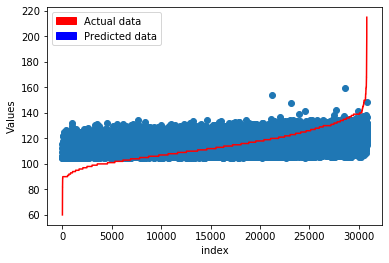

,t + 1,pred (t +1)
27282,180.0,130.943239
24270,180.0,120.557022
24956,180.0,125.281789
18018,181.0,129.246737
2983,184.0,117.521735
28399,185.0,116.754698
9193,197.0,148.202274
9347,198.0,131.108202
20428,200.0,124.512395
12,215.0,116.920502


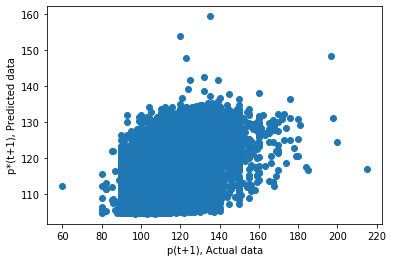

<IPython.core.display.Javascript object>

In [30]:
import math
from sklearn import metrics as m

print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

ypredPD = pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD["t + 1"] = ytest.values.ravel()
ypredPD["pred (t +1)"] = ypred
ypredPD.head(30)

import matplotlib.patches as mpatches

plt.ylabel("Values")
plt.xlabel("index")
red_patch = mpatches.Patch(color="red", label="Actual data")
blue_patch = mpatches.Patch(color="blue", label="Predicted data")
plt.legend(handles=[red_patch, blue_patch])

ypredPD = ypredPD.sort_values(by=["t + 1"])
plt.scatter(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)
plt.plot(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["t + 1"][: ypredPD.shape[0]], color="red"
)
plt.show()

plt.ylabel("p*(t+1), Predicted data")
plt.xlabel("p(t+1), Actual data")
plt.scatter(
    ypredPD["t + 1"][: ypredPD.shape[0]], ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)

ypredPD.tail(10)

xg boost
==========

In [31]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain)

[23:16:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

<IPython.core.display.Javascript object>

In [32]:
ypred = xg_reg.predict(xtest)

print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 117.32095900216657
root mean_squared_error 10.831480000543166
mean_absolute_error 8.583065198438417
r2_score 0.3100788706315776


<IPython.core.display.Javascript object>

ANN
==========

In [33]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


<IPython.core.display.Javascript object>

In [59]:
model = Sequential()
model.add(
    Dense(input_dim=25, units=128, activation="relu", kernel_initializer="uniform")
)
model.add(Dense(units=128, activation="relu", kernel_initializer="uniform"))
model.add(RBFLayer(128, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=64, activation="relu", kernel_initializer="uniform"))
model.add(RBFLayer(64, 0.5))
model.add(Dense(units=32, activation="relu", kernel_initializer="uniform"))
model.add(RBFLayer(32, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=16, activation="relu", kernel_initializer="uniform"))
model.add(RBFLayer(16, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=8, activation="relu", kernel_initializer="uniform"))
model.add(RBFLayer(8, 0.5))
model.add(Dense(units=1, kernel_initializer="uniform"))
model.compile(
    loss="mean_squared_error", optimizer="Nadam", metrics=["mean_squared_error"]
)

<IPython.core.display.Javascript object>

In [61]:
h = model.fit(xtrain, ytrain, validation_split=0.2, epochs=20, batch_size=50)

Train on 98552 samples, validate on 24639 samples
Epoch 1/20
64700/98552 [==================>...........] - ETA: 3s - loss: 171.7253 - mean_squared_error: 171.7253

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [62]:
ypred = model.predict(xtest)

import math

print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

ypredPD = pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD["t + 1"] = ytest.values.ravel()
ypredPD["pred (t +1)"] = ypred
ypredPD.head(10)

mean_squared_error 170.0911894719296
root mean_squared_error 13.041901298197653
mean_absolute_error 10.563917738592883
r2_score -0.00024331998449556025


,t + 1,pred (t +1)
0,150.0,114.258026
1,120.0,114.258026
2,124.0,114.258026
3,109.0,114.258026
4,114.0,114.258026
5,106.0,114.258026
6,98.0,114.258026
7,128.0,114.258026
8,98.0,114.258026
9,110.0,114.258026


<IPython.core.display.Javascript object>

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


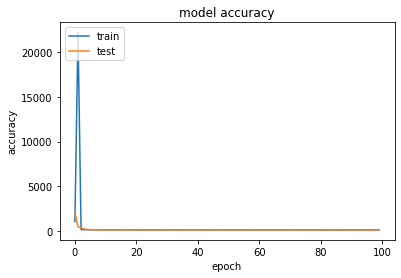

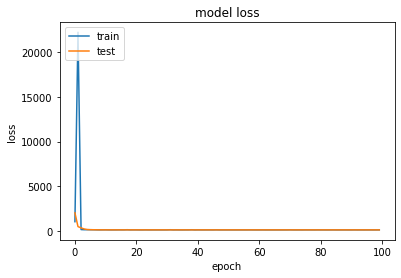

<IPython.core.display.Javascript object>

In [63]:
history = h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["val_mean_squared_error"])
plt.plot(history.history["mean_squared_error"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [64]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print(np.mean(ypredPD["diff"]))
print(np.std(ypredPD["diff"]))
print(100 * ypredPD[ypredPD["diff"] <= 5].shape[0] / ypredPD.shape[0])

10.563917738592883
7.648191386476274
27.644652250146112


<IPython.core.display.Javascript object>

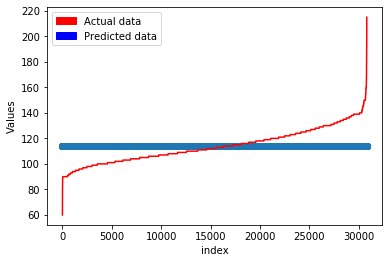

,t + 1,pred (t +1),diff
3741,60.0,114.258026,54.258026
22745,80.0,114.258026,34.258026
12066,80.0,114.258026,34.258026
22658,80.0,114.258026,34.258026
25885,80.0,114.258026,34.258026
23300,80.0,114.258026,34.258026
2803,80.0,114.258026,34.258026
1984,80.0,114.258026,34.258026
22503,80.0,114.258026,34.258026
17323,80.0,114.258026,34.258026


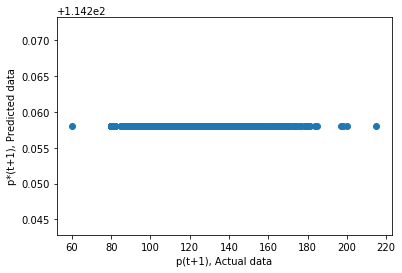

<IPython.core.display.Javascript object>

In [65]:
import matplotlib.patches as mpatches

plt.ylabel("Values")
plt.xlabel("index")
red_patch = mpatches.Patch(color="red", label="Actual data")
blue_patch = mpatches.Patch(color="blue", label="Predicted data")
plt.legend(handles=[red_patch, blue_patch])

ypredPD = ypredPD.sort_values(by=["t + 1"])
plt.scatter(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)
plt.plot(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["t + 1"][: ypredPD.shape[0]], color="red"
)
plt.show()

plt.ylabel("p*(t+1), Predicted data")
plt.xlabel("p(t+1), Actual data")
plt.scatter(
    ypredPD["t + 1"][: ypredPD.shape[0]], ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [56]:
from keras.layers import Layer
from keras import backend as K


class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(int(input_shape[1]), self.units),
            initializer="uniform",
            trainable=True,
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

<IPython.core.display.Javascript object>